#Conectar con la API de Spotify

In [121]:
import requests 
import json
import networkx as nx
import matplotlib.pyplot as plt 
import time
from tqdm import tqdm
import numpy as np
import musicbrainzngs as mb



In [ ]:
CLIENT_ID = '14c49fbcea5a4439bfa94aa591089353'
CLIENT_SECRET = '710e61b1ca974449a6c7a23c50146cca'
# POST donde le pasamos las clave de la app
response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
# Guardamos el bearer token para usarlo en las peticiones de la API
access_token = response.json()['access_token']
headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

# OAuth_Client_ID = 'SObZ1oUfqqaJS5TLsZ2Ohy4LdqMa3Mpr'
# OAuth_Client_Secret = 'kUXJwU5WqBa5C7CkjCUITfdL6NQMd-4m'
#Identificación

mb.set_useragent('redes_complejas', 0.1) 

In [ ]:
CLIENT_ID = '3a283f4bd64241238d019491e4aedca3'
CLIENT_SECRET = 'aee8c6c05d0a42c487c0069b7bd075a8'

response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
access_token = response.json()['access_token']
headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

# OAuth_Client_ID = 'SObZ1oUfqqaJS5TLsZ2Ohy4LdqMa3Mpr'
# OAuth_Client_Secret = 'kUXJwU5WqBa5C7CkjCUITfdL6NQMd-4m'
#Identificación
mb.set_useragent('redes_complejas', 0.1) 

In [123]:
mb.set_useragent('redes_complejas', 0.1) 

# Red de Colaboración de artistas

Idea: agarro un artista random, itero sobre sus canciones, y por cada canción me guardo el nombre de los artistas con los que colaboro. Por cada artista con el que colaboro repito proceso. 

Para encontrar el id de un artista tienen que abrir spotfiy y buscar al artista en cuestion y copiar todos los numeros raros que aparecen al final del link
Osea lo que va despues de : 'https://open.spotify.com/artist/..'

ahora que me guarde todas las canciones, por cada una miro si colaboro con alguien

Creo la red

#Lo hago para varios artistas a manopla, abajo lo automatizo

A veces no reconoce "items" y "artists" pero ni idea porq,. lo corro de nuevo y funca. Probando creo que es porque la api acepta una cierta cantidad de request en un tiempo.

Se me ocurrieron varias cosas del tp.

Para generar la red lo que podríamos hacer es por ejemplo, empezar con un artista cualquiera, chequear sus vecinos y a ellos hacerles todo el proceso de analizar los álbumes y generar los enlaces, así hasta que termine la red o hasta que queramos. Tipo una red ego. Lo que habría que chequear es si se puede pedir el ID de un artista pasándole su nombre.

Sino habría que scrapear una banda de artistas con sus ids y meterlos en un txt. Aunque eso lo terminaremos haciendo seguro.

La otra que se me ocurrió con machine learning es que en vez de estudiar a los años la evolución que quizá tenemos poca data es, pasarle una red incompleta y después pasarle nuevos nodos/enlaces y que nos diga de que género, género musical y país son los nodos nuevos, a ver si puede predecirlos.

La otra manera que se me ocurrió de hacer esto sin machíne learning pero no sé que tan viable es, sería analizar la homofilia de los distintos parámetros de la red y que dándole nuevos nodos, hagamos un código calculé los atributos que minimizan la diferencia de la homofilia original y la de la red, con algún algoritmo a lo modularidad.

#Definimos las cosas en funciones para agilizar el análisis.

In [119]:
def conseguir_id_y_genero(artista):
    """
    Recibe
        artista: Nombre del artista del cual se quiere su ID
    Devuelve:
        id: La ID del artista y el/los generos del artista
    """
    # End point para obtener los audio features. Esto se saca de la referencia de la documentación
    url = 'https://api.spotify.com/v1/search'

    # Búsqueda. Acá sí hay que pasarselo como parámetros
    params = {'q': f"{artista}", 'type': 'artist', 'limit': '5'}

    # En este caso no lleva ningún parámetro, el id de la canción va directamente en el url
    response = requests.get(url, params = params, headers = headers)

    # Vemos el json de la respuesta
    json_data = response.json()
    
    genero = json_data['artists']['items'][0]['genres']
    
    # Con la siguiente lista conseguimos el ID del primer resultado de la busqueda (creo)
    id = json_data["artists"]["items"][0]["id"]
    
    return (id,genero)

In [116]:

def conseguir_canciones(artista):
    """
    Recibe
        nombre: artista 
    Devuelve:
        diccionario: id de la cancion junto a su año
    """
    
    id = conseguir_id(artista)[0]
    canciones = []
    #pido la data de los albumes del artista
    url = f'https://api.spotify.com/v1/artists/{id}/albums'
    response = requests.get(url, params = {}, headers = headers)
    json_data = response.json()
    items = json_data['items']
    #me guardo todos sus albumes
    
    

    dic_canciones = {}
    
    
    for indice_album,item in enumerate(items):
        año_album = items[indice_album]['release_date']
        nombre_album = items[indice_album]['id']
        
        url = f'https://api.spotify.com/v1/albums/{nombre_album}/tracks'
        response = requests.get(url, params = {}, headers = headers)
        data_albumes = response.json()

        #itero sobre todas las canciones de cada album y la guardo en la lista de canciones
        data_canciones = data_albumes['items']

        for i in range(len(data_canciones)):
            dic_canciones[data_canciones[i]['id']] = año_album
  
    return dic_canciones

In [12]:
def conseguir_colaboradores(songs):
    """
    Recibe
        lista: lista con canciones
    Devuelve:
        lista: lista con nombres de los artistas con los que colaboró
    """
    #creo una lista con todos los nombres de los artistas con los que colaboro el artista
    colaboraciones = []
    for song in songs:
        url = f' https://api.spotify.com/v1/tracks/{song}'
        response = requests.get(url, params = {}, headers = headers)
        json_data = response.json()
        for i in range(len(json_data['artists'])):
            colaboraciones.append(json_data['artists'][i]['name'] )
  
    colaboraciones = list(dict.fromkeys(colaboraciones))  #elimino duplicados, tenerlos en cuenta si  queremos enlaces pesados
    return colaboraciones

In [13]:
def crear_enlaces(nombre_artista,colaboraciones):
    # Crea una lista con todos los enlaces
    enlaces = [(nombre_artista,colaboracion) for colaboracion in colaboraciones]

    return enlaces

In [124]:
def conseguir_pais(nombre_artista): #AGREGAR ACA SI QUEREMOS ALGUN OTRO ATRIBUTO
    
    dic_atributos = {}
    data = mb.search_artists(artist = nombre_artista, limit= 1)
    
    pais = data["artist-list"][0]["country"]
    genero = data["artist-list"][0]["gender"]
    
    dic_atributos["pais"] = pais
    dic_atributos["genero"] = genero
    
    return dic_atributos

{'pais': 'ES', 'genero': 'female'}

Creamos la red de manera (recursiva?), empezamos en la rosalia, chequeamos sus vecinos y chequeamos los vecinos de los vecinos y asi hasta que haya 2000 nodos.

In [ ]:
nombre_artista = "ROSALÍA"

# Defino una lista con todos los artistas
lista_artistas = [nombre_artista]
# Defino una lista para guardar los enlaces
lista_enlaces = []

i = 0 
while len(lista_artistas) < 2000:
    time.sleep(1.2) # Espero a ver si le estoy pidiendo demasiados request a la api, aparentemente sirve
    print(i)
    print(len(lista_artistas))
    print(" ")
    colaborador = lista_artistas[i]
    id_colaborador= conseguir_id(colaborador)
    canciones_colaborador = conseguir_canciones(id_colaborador)
    nuevos_colaboradores = conseguir_colaboradores(canciones_colaborador)[1:]

    lista_artistas += nuevos_colaboradores
    lista_enlaces += crear_enlaces(colaborador,nuevos_colaboradores)
    i += 1

0
1
 
1
10
 
2
28
 
3
50
 
4
83
 
5
135
 
6
140
 
7
166
 
8
219
 
9
257
 
10
267
 
11
323
 
12
410
 
13
480
 
14
484
 
15
511
 
16
529
 
17
565
 
18
598
 
19
630
 
20
678
 
21
686
 
22
734
 
23
775
 
24
795
 
25
832
 
26
864
 
27
904
 
28
939
 
29
961
 
30
985
 
31
1043
 
32
1096
 
33
1301
 
34
1527
 
35
1575
 
36
1602
 
37
1628
 
38
1652
 
39
1683
 
40
1711
 
41
1742
 
42
1762
 
43
1802
 
44
1864
 
45
1873
 
46
1888
 
47
1897
 
48
1935
 
49
1961
 


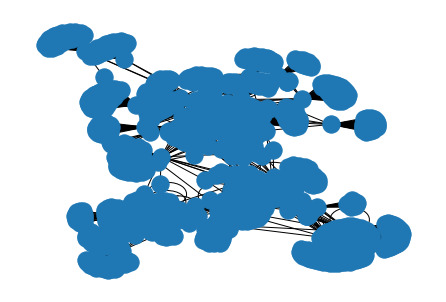

In [ ]:
red = nx.Graph()
red.add_edges_from(lista_enlaces)
nx.draw(red)

In [ ]:
print(f"la red tiene {red.number_of_nodes()} nodos y {red.number_of_edges()} enlaces")

la red tiene 1293 nodos y 1826 enlaces


Guardo la red. $i$ es el indice del artista hasta el que llego a recorrer, aumenta un montón, porque recorriendo hasta 64 artistas, la red llega a tener mas de 1500 nodos. 

No lo segui por un tema, no es que tarde tanto tiempo, seguro para hacer una red grande tarda, pero el problema es que (creo) que si le pedis mucho a la api te dejan de mandar data xd.

In [ ]:
columna0 = [enlace[0] for enlace in lista_enlaces]
columna1 = [enlace[1] for enlace in lista_enlaces]

In [ ]:
filename = f"red_rosalia_hasta_{i}.npz"
np.savez(filename, nodos = lista_artistas , enlace_1 = columna0, enlace_2= columna1)

Importo la red

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) # Montamos nuestra unidad de Google Drive

Mounted at /content/drive


In [ ]:
filename = '/content/drive/My Drive/Redes Complejas/TP Final/Archivos/red_rosalia_hasta_64.npz'
npzfile = np.load(filename)

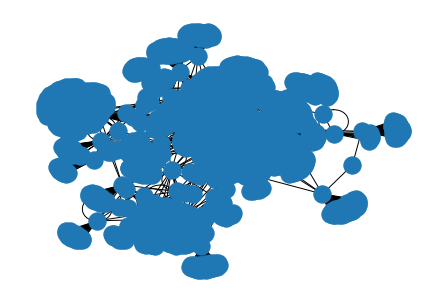

In [ ]:
lista_artistas = list(npzfile['nodos'])
lista_enlaces = [(npzfile['enlace_1'][i], npzfile['enlace_2'][i]) for i in range(len(npzfile['enlace_1']))]


red= nx.Graph()
red.add_edges_from(lista_enlaces)
nx.draw(red)

Se ve joya!

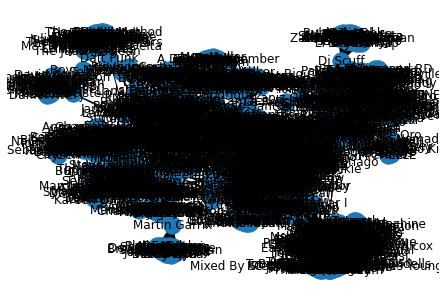

In [ ]:
nx.draw(red,with_labels = True)

In [ ]:
print(f"la red tiene {red.number_of_nodes()} nodos y {red.number_of_edges()} enlaces")

la red tiene 1535 nodos y 2403 enlaces
